### Autoencoder
Il primo modello creato è l'autoencoder e usa gli stessi principi delle CNN per creare una rappresentazione compatta delle immagini. Infatti il modello è composto da dei Convolutional Layer che, riducono la dimensione spaziale per aumentare la dimensionde dei filtri.\
L'encoder ha inoltre dei layer di BatchNormalization.

Questo modello è quello più lungo da addestrare solamente perchè ha abbastanza parametri e il dataset, essendo grande, non ci sta in memoria.\
Per queste ragioni la batch è piccola e generata da una funzione.

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, callbacks, ops, random, metrics, losses, saving

dataset_path = '../datasets/covid_cxr_cache.npy'
model_save_path = '../models/autoencoder_vae.keras'
model_save_path_encoder = '../models/autoencoder_vae_encoder.keras'

latent_space = 128
epochs = 50
batch = 32

E0000 00:00:1745416911.313011  210444 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745416911.338685  210444 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745416911.527243  210444 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745416911.527273  210444 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745416911.527275  210444 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745416911.527277  210444 computation_placer.cc:177] computation placer already registered. Please check linka

Qui carichiamo il dataset e il modello dalla classe creata apposta. Il modello preso sarà caricato o da file (e quindi non verrà addestrato) oppure viene costruito e poi addestrato.

In [2]:
dataset = np.load(dataset_path, allow_pickle=True).item()

(x_train, _) = dataset['train']
(x_val, _) = dataset['val']
(x_test, _) = dataset['test']

shape = x_train.shape[1:]

Il layer di sampling

In [3]:
@saving.register_keras_serializable()
class Sampling(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


Di seguito la classe del VAE con il custom learning step

In [4]:
@saving.register_keras_serializable()
class VAE(models.Model):
    def __init__(self, latent_dim=128, **kwargs):
        super().__init__(**kwargs)
        encoder, decoder = VAE.build_encoder_decoder(latent_dim)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    def build_encoder_decoder(latent_dim):
        in_encoder = layers.Input(shape=shape, dtype='float32')
        x = layers.BatchNormalization()(in_encoder)
        x = layers.Conv2D(32, 3, padding='same', strides=2)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = layers.Conv2D(64, 3, padding='same', strides=2)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = layers.Conv2D(128, 3, padding='same', strides=2)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = layers.Conv2D(256, 3, padding='same', strides=2)(x)
        x = layers.BatchNormalization()(x)
        before_flatten = x.shape[1:]
        x = layers.Flatten()(x)
        flatten = x.shape[1]
        x = layers.LeakyReLU()(x)
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        encoder = models.Model(in_encoder, [z_mean, z_log_var, z], name='encoder')

        in_decoder = layers.Input(shape=(latent_dim,))
        x = layers.Dense(flatten)(in_decoder)
        x = layers.LeakyReLU()(x)
        x = layers.Reshape(before_flatten)(x)
        x = layers.Conv2DTranspose(256, 3, padding='same', strides=2)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Conv2DTranspose(128, 3, padding='same', strides=2)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Conv2DTranspose(64, 3, padding='same', strides=2)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Conv2DTranspose(32, 3, padding='same', strides=2)(x)
        x = layers.LeakyReLU()(x)
        out_decoder = layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)
        decoder = models.Model(in_decoder, out_decoder, name='decoder')

        return encoder, decoder

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction = losses.mean_squared_error(data[0], reconstruction)
            reconstruction_loss = ops.mean(ops.sum(reconstruction, axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, *args, **kwargs):
        _, _, z = self.encoder(*args, **kwargs)
        reconstruction = self.decoder(z)
        return reconstruction

In [5]:
vae = VAE(latent_space)
vae.compile(optimizer='adam', loss=['loss'])
vae.summary()

I0000 00:00:1745416916.224637  210444 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5557 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 128), (None,   │    13,235,076 │
│                                 │ 128), (None, 128))     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 224, 224, 1)    │     7,450,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,685,445 (78.91 MB)

 Trainable params: 20,684,483 (78.91 MB)

 Non-trainable params: 962 (3.76 KB)

In questa porzione di codice il modello viene addestrato

In [ ]:
def data_generator(x, batch_size):
    indices = np.arange(len(x))
    while True:
        np.random.shuffle(indices)
        for i in range(0, len(x), batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_data = x[batch_indices].astype('float32') / 255.0
            yield batch_data, 

batch_steps = len(x_train) // batch + 1
batch_val_steps = len(x_val) // batch + 1
gen_train = data_generator(x_train, batch)
gen_val = data_generator(x_val, batch)

history = vae.fit(gen_train, epochs=epochs, steps_per_epoch=batch_steps,
                  callbacks=[callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor='loss', mode='min')],)
                #   validation_data=gen_val, validation_steps=batch_val_steps)
vae.encoder.save(model_save_path_encoder)

Epoch 1/50


/home/berack/upo-AIContrastive/.venv_tf/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 224, 224, 1))',)
  warnings.warn(msg)
I0000 00:00:1745416919.623370  210571 service.cc:152] XLA service 0x7f23d80248f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745416919.623408  210571 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
I0000 00:00:1745416920.075781  210571 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2121 ━━━━━━━━━━━━━━━━━━━━ 7:10:37 12s/step - kl_loss: 0.1238 - loss: 2948.0364 - reconstruction_loss: 2947.9126

I0000 00:00:1745416929.243714  210571 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2121/2121 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - kl_loss: 82.7518 - loss: 642.8995 - reconstruction_loss: 560.1477

/home/berack/upo-AIContrastive/.venv_tf/lib/python3.12/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


2121/2121 ━━━━━━━━━━━━━━━━━━━━ 94s 38ms/step - kl_loss: 82.7526 - loss: 642.7996 - reconstruction_loss: 560.0469
Epoch 2/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 74s 35ms/step - kl_loss: 82.3118 - loss: 314.0121 - reconstruction_loss: 231.7002
Epoch 3/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 74s 35ms/step - kl_loss: 82.1795 - loss: 299.9314 - reconstruction_loss: 217.7519
Epoch 4/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 74s 35ms/step - kl_loss: 81.7955 - loss: 291.2362 - reconstruction_loss: 209.4408
Epoch 5/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 74s 35ms/step - kl_loss: 81.1668 - loss: 285.1638 - reconstruction_loss: 203.9972
Epoch 6/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 75s 35ms/step - kl_loss: 80.5628 - loss: 281.4141 - reconstruction_loss: 200.8514
Epoch 7/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 74s 35ms/step - kl_loss: 80.1420 - loss: 278.9226 - reconstruction_loss: 198.7807
Epoch 8/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 74s 35ms/step - kl_loss: 79.8850 - loss: 274.7883 - reconstruction_loss: 194.9032
Epoch 9/50
2121/212

Di seguito viene mostrato il valore e il grafico della loss per il modello dell'autoencoder.

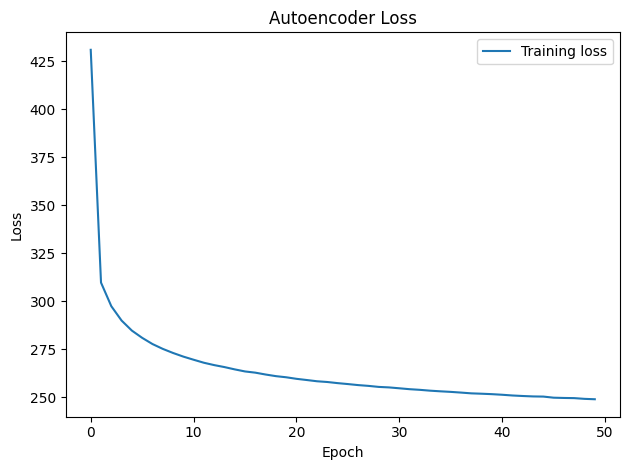

In [ ]:
plt.figure(figsize=None)
plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
plt.title(f'Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Di seguto vengono presi 10 casi di test, mostrati e ricostruiti

/home/berack/upo-AIContrastive/.venv_tf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


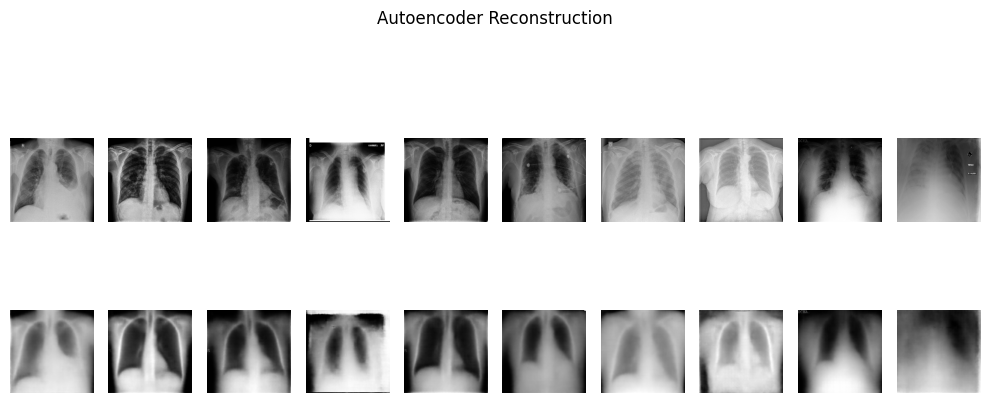

In [8]:
autoencoder = models.load_model(model_save_path)

total_rand = 10
rand_indices = np.random.choice(len(x_test), total_rand, replace=False)

x_test_rand = x_test[rand_indices] / 255.0
x_test_reconstructed = autoencoder.predict(x_test_rand, verbose=0)

plt.figure(figsize=(10, 5))
for i in range(total_rand):
    plt.subplot(2, total_rand, i + 1)
    plt.imshow(x_test_rand[i].reshape(shape), cmap='gray')
    plt.axis('off')
    plt.subplot(2, total_rand, i + 1 + total_rand)
    plt.imshow(x_test_reconstructed[i].reshape(shape), cmap='gray')
    plt.axis('off')
plt.suptitle('Autoencoder Reconstruction')
plt.tight_layout()
plt.show()